# **Installing Essential Packages**

In [ ]:
!pip install pdf2image
!apt-get install poppler-utils

# **Importing Essential Libraries**

In [92]:
import os
import cv2
import json
import math
import unicodedata
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import sobel
from pdf2image import convert_from_path
from skimage.segmentation import active_contour
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# **Converting PDF to Image**

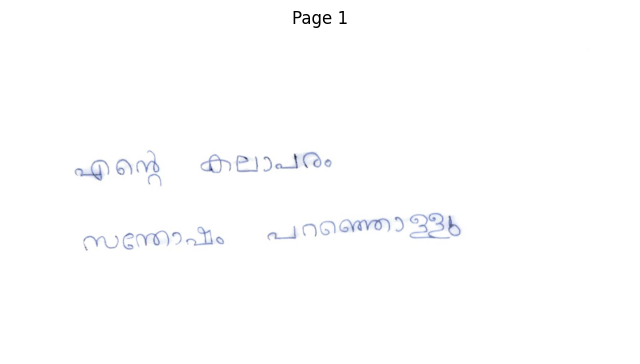

1 page(s) saved to '/content/sample_data/PDF_to_Image' and displayed.


In [67]:
def pdf_to_images(pdf_path, output_folder='/content/sample_data/PDF_to_Image'):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert PDF to images
    images = convert_from_path(pdf_path)

    # Save and display each page
    for i, img in enumerate(images):
        img_path = os.path.join(output_folder, f"{i + 1}.jpg")
        img.save(img_path, 'JPEG')  # You used .jpg in the filename

        # Show the image
        plt.figure(figsize=(8, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Page {i + 1}')
        plt.show()

    print(f"{len(images)} page(s) saved to '{output_folder}' and displayed.")

# Example usage
pdf_to_images('/content/input.pdf')  # Replace with your actual PDF path


# **Line Segmentation**

Processing 1.jpg, Shape: (883, 1700)

 Displaying 2 saved line images:



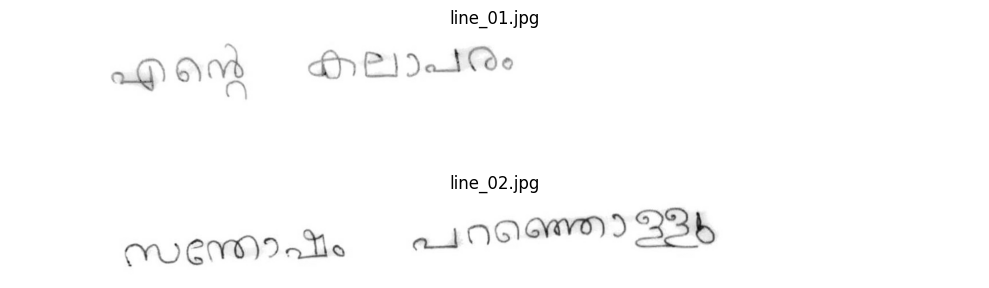

 Total 2 lines saved and displayed from '/content/sample_data/Segmented_Lines'


In [54]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Input and output directories
input_dir = "/content/sample_data/PDF_to_Image"
output_dir = "/content/sample_data/Segmented_Lines"
os.makedirs(output_dir, exist_ok=True)

# Global line counter
line_count = 0

# Iterate over all images in the input directory
for file_name in sorted(os.listdir(input_dir)):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_dir, file_name)

        # Load the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        print(f"Processing {file_name}, Shape: {image.shape}")

        # Threshold the image to binary
        _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Compute horizontal projection
        hist = np.sum(binary_image, axis=1)

        # Detect start and end positions of lines
        line_positions = []
        start = None
        for i, value in enumerate(hist):
            if value > 0 and start is None:
                start = i
            elif value == 0 and start is not None:
                end = i
                if end - start > 10:
                    line_positions.append((start, end))
                start = None

        # Extract and save line images
        for (start_row, end_row) in line_positions:
            top_margin = 20
            bottom_margin = 20

            line_image = image[max(0, start_row - top_margin):min(image.shape[0], end_row + bottom_margin), :]

            line_count += 1
            output_path = os.path.join(output_dir, f"line_{line_count:02}.jpg")
            cv2.imwrite(output_path, line_image)

# Display all processed line images from the output folder
line_images = sorted([f for f in os.listdir(output_dir) if f.endswith('.jpg')])

print(f"\n Displaying {len(line_images)} saved line images:\n")
plt.figure(figsize=(10, len(line_images) * 2))
for idx, file_name in enumerate(line_images):
    img_path = os.path.join(output_dir, file_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(len(line_images), 1, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{file_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f" Total {line_count} lines saved and displayed from '{output_dir}'")


# **Word Segmentation**

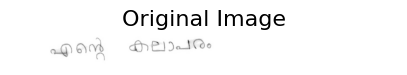

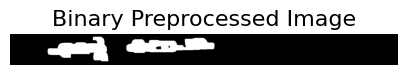

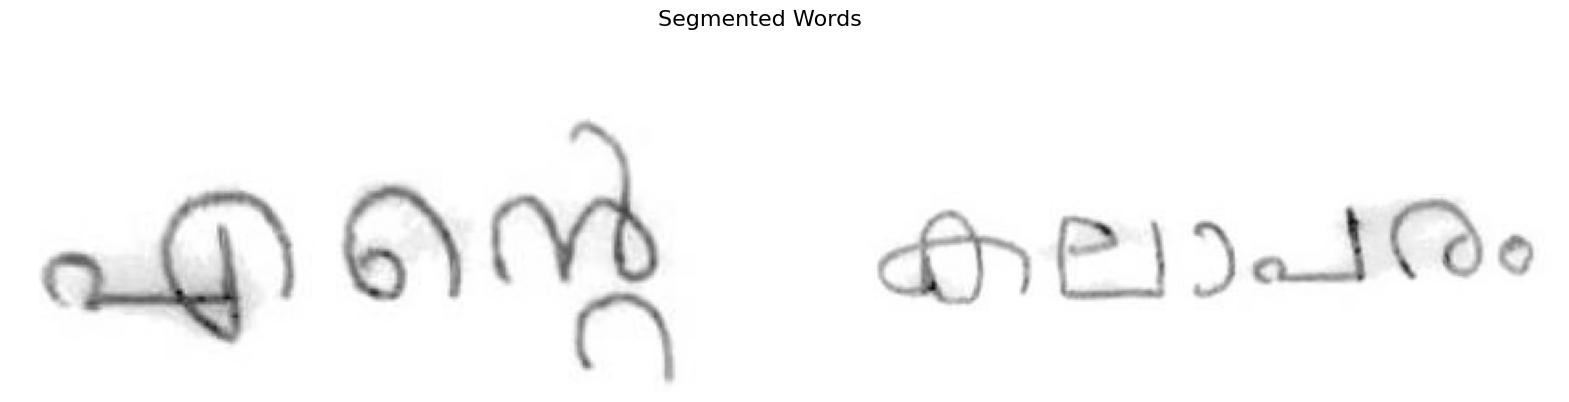

Processed line_01.jpg, segmented words saved in /content/sample_data/Segmented_Words/line01


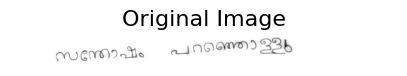

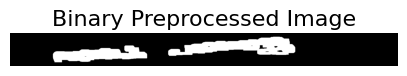

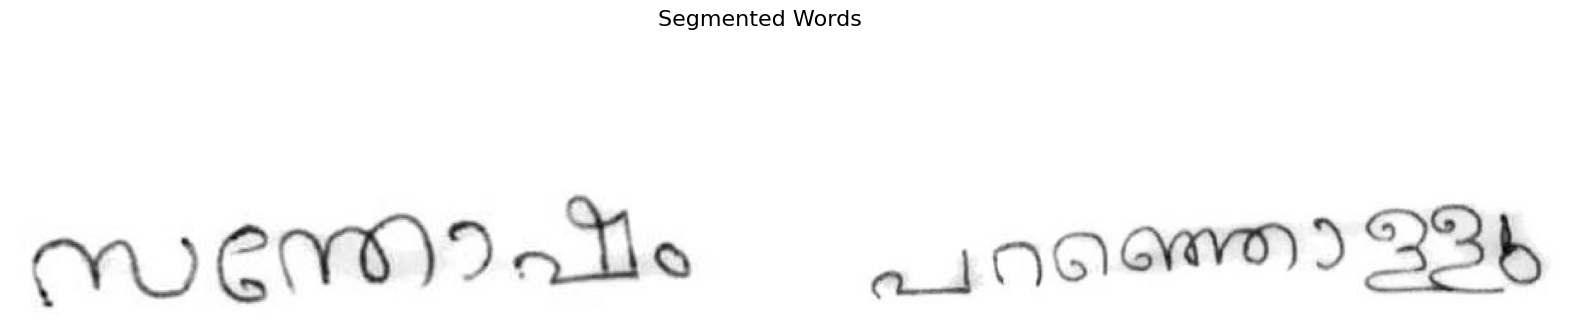

Processed line_02.jpg, segmented words saved in /content/sample_data/Segmented_Words/line02


In [55]:
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    binary = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=10
    )

    kernel_width = max(20, image.shape[1] // 50)
    kernel_height = max(5, image.shape[0] // 100)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_close)

    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
    dilated = cv2.dilate(closed, kernel_dilate, iterations=2)

    return dilated

def segment_words(image, binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    sorted_bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])
    word_images = []

    for x, y, w, h in sorted_bounding_boxes:
        word_img = image[y:y + h, x:x + w]
        word_images.append(word_img)

    return word_images

def process_line_image(input_image_path, output_folder):
    image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error reading image: {input_image_path}")
        return

    binary_image = preprocess_image(image)
    word_images = segment_words(image, binary_image)

    save_segmented_words(word_images, output_folder)
    display_images([image], "Original Image")
    display_images([binary_image], "Binary Preprocessed Image")
    display_images(word_images, "Segmented Words")

def save_segmented_words(word_images, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, word_img in enumerate(word_images):
        word_path = os.path.join(output_folder, f"word_{i + 1}.jpg")
        cv2.imwrite(word_path, word_img)

def display_images(images, title):
    if len(images) == 1:
        plt.figure(figsize=(5, 5))
        plt.imshow(images[0], cmap='gray')
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()
    else:
        fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
        fig.suptitle(title, fontsize=16)
        for ax, img in zip(axes, images):
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.show()

def process_directory(input_dir, output_dir):
    input_images = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]
    for image_name in sorted(input_images):
        image_path = os.path.join(input_dir, image_name)

        # Create output folder with same line number name (ex: line01, line02, ...)
        line_num = image_name.split('.')[0].split('_')[-1]  # e.g. line_01 → 01
        line_output_folder = os.path.join(output_dir, f"line{line_num}")

        if not os.path.exists(line_output_folder):
            os.makedirs(line_output_folder)

        process_line_image(image_path, line_output_folder)
        print(f"Processed {image_name}, segmented words saved in {line_output_folder}")

# Updated usage with your directory structure
input_dir = '/content/sample_data/Segmented_Lines'  # Input: line_01.jpg, ...
output_dir = '/content/sample_data/Segmented_Words' # Output: line01/word_1.jpg, ...

process_directory(input_dir, output_dir)


# **Character Segmentation**

Processing: /content/sample_data/Segmented_Words/line01/word_1.jpg


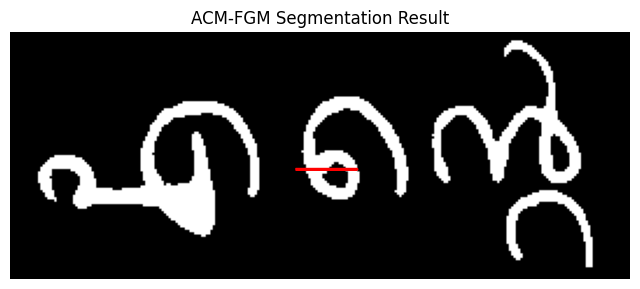

Saved 4 characters to /content/sample_data/Segmented_Characters/line01/word_1


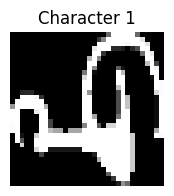

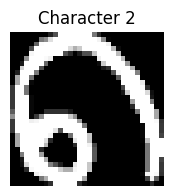

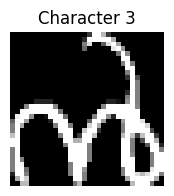

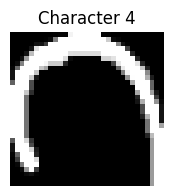

Processing: /content/sample_data/Segmented_Words/line01/word_2.jpg


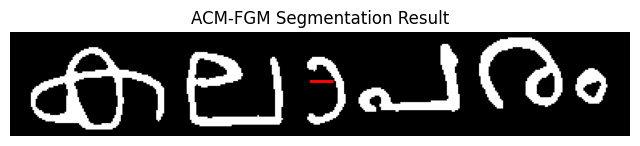

Saved 6 characters to /content/sample_data/Segmented_Characters/line01/word_2


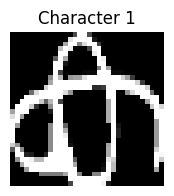

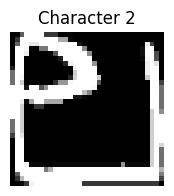

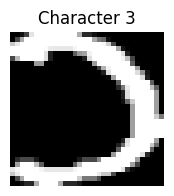

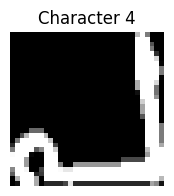

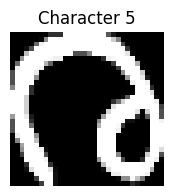

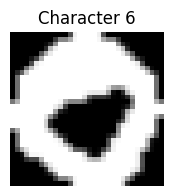

Processing: /content/sample_data/Segmented_Words/line02/word_1.jpg


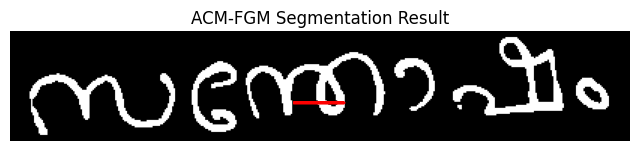

Saved 6 characters to /content/sample_data/Segmented_Characters/line02/word_1


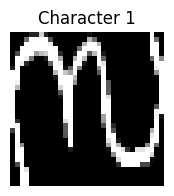

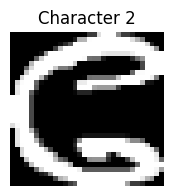

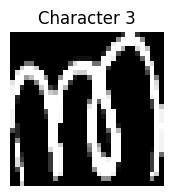

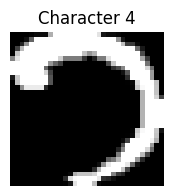

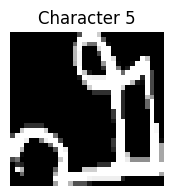

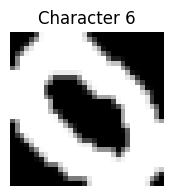

Processing: /content/sample_data/Segmented_Words/line02/word_2.jpg


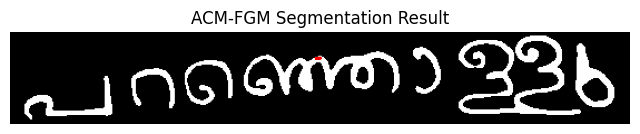

Saved 7 characters to /content/sample_data/Segmented_Characters/line02/word_2


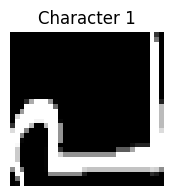

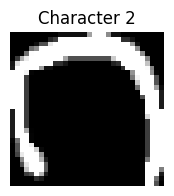

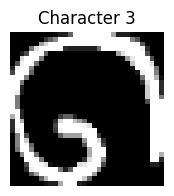

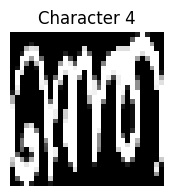

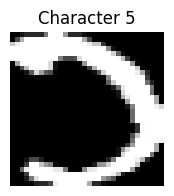

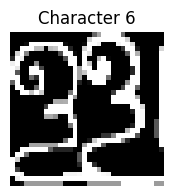

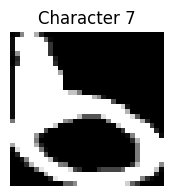

In [56]:
def read_images_from_folder(folder_path):
    images = []
    filenames = []

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.jpeg', '.jpg')):
            image_path = os.path.join(folder_path, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                filenames.append(file_name)
            else:
                print(f"Error loading image: {file_name}")
    return images, filenames

def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary

def segment_characters_acm(image):
    gradient = sobel(image)

    init_contour = np.array([
        [10, 10],
        [10, image.shape[1] - 10],
        [image.shape[0] - 10, image.shape[1] - 10],
        [image.shape[0] - 10, 10]
    ])

    snake = active_contour(
        gradient,
        init_contour,
        alpha=0.1,
        beta=0.1,
        gamma=0.01
    )

    contours, _ = cv2.findContours(
        image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    sorted_bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

    character_images = []
    for x, y, w, h in sorted_bounding_boxes:
        if w > 5 and h > 5:
            char_img = image[y:y + h, x:x + w]
            resized_char = cv2.resize(char_img, (32, 32))
            character_images.append(resized_char)

    # Visualize the snake
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
    plt.title("ACM-FGM Segmentation Result")
    plt.axis('off')
    plt.show()

    return character_images

def process_images(input_base_folder, output_base_folder):
    # Loop through each line folder
    for line_folder in sorted(os.listdir(input_base_folder)):
        line_path = os.path.join(input_base_folder, line_folder)
        if not os.path.isdir(line_path):
            continue

        # Loop through each word image inside that line folder
        for word_file in sorted(os.listdir(line_path)):
            if not word_file.endswith(('.jpg', '.jpeg')):
                continue

            word_path = os.path.join(line_path, word_file)
            word_img = cv2.imread(word_path, cv2.IMREAD_GRAYSCALE)
            if word_img is None:
                print(f"Error loading image: {word_path}")
                continue

            print(f"Processing: {word_path}")
            preprocessed = preprocess_image(word_img)
            characters = segment_characters_acm(preprocessed)

            # Save to Segmented_Characters/lineXX/word_YY/char_1.jpg ...
            word_name = os.path.splitext(word_file)[0]
            save_path = os.path.join(output_base_folder, line_folder, word_name)
            os.makedirs(save_path, exist_ok=True)

            for i, char_img in enumerate(characters):
                char_filename = f"char_{i + 1}.jpg"
                cv2.imwrite(os.path.join(save_path, char_filename), char_img)

            print(f"Saved {len(characters)} characters to {save_path}")

            # Show character samples
            for i in range(len(characters)):
                plt.figure(figsize=(2, 2))
                plt.imshow(characters[i], cmap='gray')
                plt.title(f"Character {i + 1}")
                plt.axis('off')
                plt.show()

# Example usage with expected folder structure
input_folder = '/content/sample_data/Segmented_Words'        # Input: lineXX/word_N.jpg
output_folder = '/content/sample_data/Segmented_Characters'  # Output: lineXX/word_N/char_1.jpg

process_images(input_folder, output_folder)


# **Custom Datset Formation(CSV File Creation)**

In [68]:
def natural_sort_key(filename):
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', filename)]

def preprocess_and_save_to_csv(dataset_path, output_dir, csv_path, img_size=(32, 32)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    data = []
    labels = []

    print(f"Dataset path: {dataset_path}")
    print(f"Output directory: {output_dir}")
    print(f"CSV path: {csv_path}")

    # Look into Segmented_Characters/lineXX/wordYY/*.jpg
    segmented_characters_path = os.path.join(dataset_path, 'Segmented_Characters')
    if not os.path.exists(segmented_characters_path):
        print(f"Error: Segmented characters directory does not exist: {segmented_characters_path}")
        return

    # Traverse line folders
    for line_folder in sorted(os.listdir(segmented_characters_path), key=natural_sort_key):
        line_path = os.path.join(segmented_characters_path, line_folder)
        if not os.path.isdir(line_path):
            continue

        print(f"Processing line: {line_folder}")

        # Traverse word folders inside each line
        for word_folder in sorted(os.listdir(line_path), key=natural_sort_key):
            word_path = os.path.join(line_path, word_folder)
            if not os.path.isdir(word_path):
                continue

            print(f"  Processing word: {word_folder}")

            for i, img_file in enumerate(sorted(os.listdir(word_path), key=natural_sort_key)):
                if not img_file.endswith('.jpg'):
                    continue

                img_path = os.path.join(word_path, img_file)
                print(f"    Processing image: {img_path}")

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"    Skipping unreadable image: {img_path}")
                    continue

                label = i + 1  # Labeling by order within word
                labels.append(label)

                img = img.astype(np.float32) / 255.0
                img = np.round(img)
                img = cv2.resize(img, img_size)

                # Save image
                save_path = os.path.join(output_dir, line_folder, word_folder)
                os.makedirs(save_path, exist_ok=True)
                output_path = os.path.join(save_path, img_file)
                cv2.imwrite(output_path, (img * 255).astype(np.uint8))

                # Column-wise flatten
                img_vectorized = img.T.flatten()
                data.append([label] + img_vectorized.tolist())

    if not data:
        print("Warning: No data was processed. Check if the directory structure and file naming are correct.")

    column_names = ['Label'] + [f'Pixel_{i}' for i in range(img_size[0] * img_size[1])]
    df = pd.DataFrame(data, columns=column_names)

    if df.empty:
        print("Warning: The DataFrame is empty. No data was added to the CSV.")
    else:
        df.to_csv(csv_path, index=False)
        print(f" CSV file saved at: {csv_path}")

# Define paths for Google Colab environment
custom_dataset_path = '/content/sample_data/'  # Assuming Segmented_Characters is here
output_directory = '/content/sample_data/preprocessed_images/'  # Where processed images will be saved
csv_file_path = '/content/sample_data/custom_dataset.csv'  # Output CSV path


# Run
preprocess_and_save_to_csv(custom_dataset_path, output_directory, csv_file_path)
print(" Processing and CSV creation complete!")


Dataset path: /content/sample_data/
Output directory: /content/sample_data/preprocessed_images/
CSV path: /content/sample_data/custom_dataset.csv
Processing line: line01
  Processing word: word_1
    Processing image: /content/sample_data/Segmented_Characters/line01/word_1/char_1.jpg
    Processing image: /content/sample_data/Segmented_Characters/line01/word_1/char_2.jpg
    Processing image: /content/sample_data/Segmented_Characters/line01/word_1/char_3.jpg
    Processing image: /content/sample_data/Segmented_Characters/line01/word_1/char_4.jpg
  Processing word: word_2
    Processing image: /content/sample_data/Segmented_Characters/line01/word_2/char_1.jpg
    Processing image: /content/sample_data/Segmented_Characters/line01/word_2/char_2.jpg
    Processing image: /content/sample_data/Segmented_Characters/line01/word_2/char_3.jpg
    Processing image: /content/sample_data/Segmented_Characters/line01/word_2/char_4.jpg
    Processing image: /content/sample_data/Segmented_Characters/li

# **Storing the Structure of Original Document as JSON File**

In [69]:
def build_structure_json(root_path):
    structure = {}

    for line_folder in sorted(os.listdir(root_path)):
        line_path = os.path.join(root_path, line_folder)
        if not os.path.isdir(line_path):
            continue

        structure[line_folder] = {}

        for word_folder in sorted(os.listdir(line_path)):
            word_path = os.path.join(line_path, word_folder)
            if not os.path.isdir(word_path):
                continue

            char_files = sorted([
                f for f in os.listdir(word_path)
                if f.endswith('.jpg') or f.endswith('.png')
            ])
            structure[line_folder][word_folder] = char_files

    return structure

# Path to the Segmented_Characters folder
segmented_characters_path = '/content/sample_data/Segmented_Characters'  # Adjust if needed

# Build structure
structure_dict = build_structure_json(segmented_characters_path)

# Save as JSON
json_path = '/content/document_structure.json'
with open(json_path, 'w') as f:
    json.dump(structure_dict, f, indent=4)

print(f" JSON structure saved to: {json_path}")


 JSON structure saved to: /content/document_structure.json


# **Displaying the Contents(Images) in the CSV File**

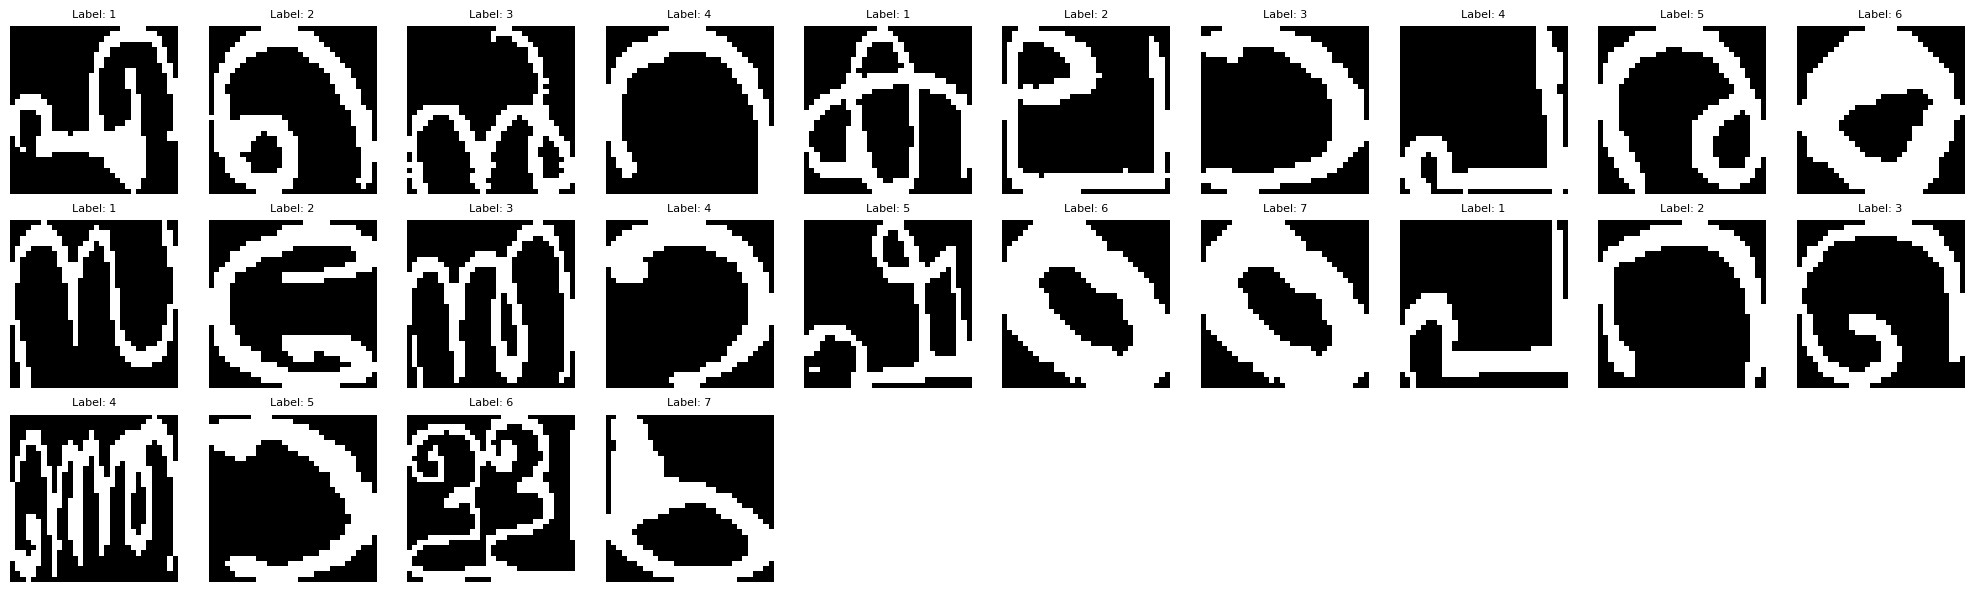

In [70]:
def load_and_show_all_images(csv_path, img_size=(32, 32), images_per_row=10):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Extract labels and image data
    labels = df.iloc[:, 0].values
    images = df.iloc[:, 1:].values

    num_images = len(images)
    num_rows = math.ceil(num_images / images_per_row)

    # Create a figure
    plt.figure(figsize=(images_per_row * 2, num_rows * 2))

    for i in range(num_images):
        plt.subplot(num_rows, images_per_row, i + 1)
        image = images[i].reshape(img_size[1], img_size[0]).T  # column-wise reshape
        plt.imshow(image, cmap='gray', vmin=0, vmax=1)
        plt.title(f"Label: {labels[i]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
csv_file_path = '/content/sample_data/custom_dataset.csv'  # Update if your path differs
load_and_show_all_images(csv_file_path)


# **Loading and Testing the Model**

In [93]:
def load_csv_data(file_path, img_size=(32, 32)):
    data = pd.read_csv(file_path)
    labels = data.iloc[:, 0].values  # First column contains labels
    images = data.iloc[:, 1:].values  # Remaining columns contain pixel values
    images = images.reshape(-1, img_size[0], img_size[1])  # Reshape to (num_samples, img_size[0], img_size[1])
    return images, labels

# Preprocessing function: normalize and standardize the dataset
def preprocess_images(images):
    img_size=(32,32)
    images = np.array([np.rot90(np.fliplr(img)) for img in images])
    #resized_images = np.array([cv2.resize(img, img_size, interpolation=cv2.INTER_AREA) for img in images])
    #images = images / 255.0  # Normalize to [0, 1]
    #mean = np.mean(images, axis=0)  # Calculate the mean for mean subtraction
    #std = np.std(images, axis=0) + 1e-7  # Avoid division by zero
    #images = (images - mean) / std  # Standardize images
    return images

test_csv = '/content/Handwritten_V2_test.csv'
model = load_model('/content/malayalam_handwriting_model.h5')
num_classes = 86
X_test, y_test = load_csv_data(test_csv)
X_test = preprocess_images(X_test)
X_test = X_test[..., np.newaxis]
y_test = to_categorical(y_test, num_classes)


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9123 - loss: 0.5948
Test Accuracy: 91.32%


# **Class Map for Prediction**

In [94]:
class_map = {
    1: '്',
    2: 'ാ',
    3: 'ി',
    4: 'ീ',
    5: 'ു',
    6: 'ൂ',
    7: 'ൃ',
    8: 'െ',
    9: 'േ',
    10: 'ൗ',
    11: 'ം',
    12: 'അ',
    13: 'ആ',
    14: 'ഇ',
    15: 'ഉ',
    16: 'ഋ',
    17: 'എ',
    18: 'ഏ',
    19: 'ഒ',
    20: 'ക',
    21: 'ഖ',
    22: 'ഗ',
    23: 'ഘ',
    24: 'ങ',
    25: 'ച',
    26: 'ഛ',
    27: 'ജ',
    28: 'ഝ',
    29: 'ഞ',
    30: 'ട',
    31: 'ഠ',
    32: 'ഡ',
    33: 'ഢ',
    34: 'ണ',
    35: 'ത',
    36: 'ഥ',
    37: 'ദ',
    38: 'ധ',
    39: 'ന',
    40: 'പ',
    41: 'ഫ',
    42: 'ബ',
    43: 'ഭ',
    44: 'മ',
    45: 'യ',
    46: 'ര',
    47: 'റ',
    48: 'ല',
    49: 'ള',
    50: 'ഴ',
    51: 'വ',
    52: 'ശ',
    53: 'ഷ',
    54: 'സ',
    55: 'ഹ',
    56: 'ൺ',
    57: 'ൻ',
    58: 'ർ',
    59: 'ൽ',
    60: 'ൾ',
    61: 'ക്ക',
    62: 'ക്ഷ',
    63: 'ങ്ക',
    64: 'ങ്ങ',
    65: 'ച്ച',
    66: 'ഞ്ച',
    67: 'ഞ്ഞ',
    68: 'ട്ട',
    69: 'ണ്ട',
    70: 'ണ്ണ',
    71: 'ത്ത',
    72: 'ദ്ധ',
    73: 'ന്ത',
    74: 'ന്ദ',
    75: 'ന്ന',
    76: 'പ്പ',
    77: 'മ്പ',
    78: 'മ്മ',
    79: 'യ്യ',
    80: 'ല്ല',
    81: 'ള്ള',
    82: 'വ്വ',
    83: '്യ',
    84: '്ര',
    85: '്വ'
}

# **Prediction and Formation of Output File**

In [96]:
# Load and preprocess custom dataset
test_csv_custom = "/content/sample_data/custom_dataset.csv"
X_test_custom, y_test_custom = load_csv_data(test_csv_custom)
X_test_custom = preprocess_images(X_test_custom)
X_test_custom = X_test_custom[..., np.newaxis]
y_test_custom = to_categorical(y_test_custom, num_classes)

# Load JSON structure
with open('/content/document_structure.json', 'r') as f:
    structure = json.load(f)

def reorder_prebase_vowels(chars):
    """
    Moves pre-base vowel signs (െ,േ,ൈ) to immediately after the consonant they belong to.
    E.g., ['െ', 'സ', 'ന്'] → ['സ', 'െ', 'ന്']
    """
    pre_base_signs = {'െ', 'േ', 'ൈ'}
    i = 0
    while i < len(chars) - 1:
        if chars[i] in pre_base_signs:
            # Grab the vowel
            vowel = chars.pop(i)
            # Insert it after the next character (i.e., original+1 position)
            insert_pos = min(i + 1, len(chars))  # Avoid index error
            chars.insert(insert_pos, vowel)
            i = insert_pos + 1  # Skip over moved vowel and next character
        else:
            i += 1
    return chars


# Predict characters
predicted_labels = []
for i in range(len(X_test_custom)):
    test_image = X_test_custom[i]
    test_image_input = np.expand_dims(test_image, axis=0)
    predicted_probs = model.predict(test_image_input, verbose=0)
    predicted_label = predicted_probs.argmax()
    predicted_labels.append(predicted_label)

# Convert predicted labels to characters
predicted_chars = [class_map.get(label, '?') for label in predicted_labels]

# Reconstruct structured text with proper reordering
output_lines = []
index = 0

for line_key in sorted(structure.keys(), key=lambda x: int(x.replace("line", ""))):
    words = []
    for word_key in sorted(structure[line_key].keys(), key=lambda x: int(x.replace("word_", ""))):
        chars = []
        for _ in structure[line_key][word_key]:
            if index < len(predicted_chars):
                chars.append(predicted_chars[index])
                index += 1

        # Reorder pre-base vowel signs (e.g., െ, േ)
        reordered_chars = reorder_prebase_vowels(chars)
        word_text = ''.join(reordered_chars)
        words.append(word_text)

    line_text = " ".join(words)
    output_lines.append(line_text)

# Normalize and write final output to file
output_text_path = '/content/output.txt'
with open(output_text_path, 'w', encoding='utf-8') as f:
    for line in output_lines:
        normalized_line = unicodedata.normalize('NFC', line)
        f.write(normalized_line + '\n')

print(f" Malayalam text correctly reordered, normalized, and saved to: {output_text_path}")


 Malayalam text correctly reordered, normalized, and saved to: /content/output.txt


# **Download the created Directories(if necessary)**

In [102]:
import shutil
# Change the directory path as necessary
shutil.make_archive('/content/sample_data/preprocessed_images', 'zip', '/content/sample_data/preprocessed_images')
from google.colab import files
files.download('/content/sample_data/preprocessed_images.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>